# 서울 상권 매출 시각화

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import platform

# 한글 폰트 설정
if platform.system() == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    plt.rc('font', family='Malgun Gothic')
else:  # other OS
    # Nanum font needs to be installed
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

In [2]:
def load_preprocessed_data(data_dir):
    """Load all preprocessed pickle files and concatenate them."""
    print(f"Loading data from {data_dir}...")
    pickle_files = list(Path(data_dir).glob('*_preprocessed.pkl'))
    if not pickle_files:
        raise FileNotFoundError(f"No preprocessed pickle files found in {data_dir}")

    df_list = [pd.read_pickle(file) for file in pickle_files]
    df = pd.concat(df_list, ignore_index=True)
    print(f"Loaded and concatenated {len(pickle_files)} files.")
    print(f"Total records: {len(df):,}")
    return df

processed_data_dir = 'data/processed'
df = load_preprocessed_data(processed_data_dir)

Loading data from data/processed...
Loaded and concatenated 5 files.
Total records: 434,199


In [3]:
# '경제활동가능인구' 컬럼 생성 (20대 ~ 60대 이상 매출 합계)
df['ECNMY_ACTIVE_POP_SELNG_AMT'] = df['AGRDE_20_SELNG_AMT'] + df['AGRDE_30_SELNG_AMT'] + df['AGRDE_40_SELNG_AMT'] + df['AGRDE_50_SELNG_AMT'] + df['AGRDE_60_ABOVE_SELNG_AMT']

print("'경제활동가능인구 매출' 컬럼이 생성되었습니다.")
print(df[['THSMON_SELNG_AMT', 'ECNMY_ACTIVE_POP_SELNG_AMT']].head())

'경제활동가능인구 매출' 컬럼이 생성되었습니다.
   THSMON_SELNG_AMT  ECNMY_ACTIVE_POP_SELNG_AMT
0         382839289                   319847432
1         122957138                   111437792
2          19012827                    15069260
3          37551380                    37551380
4         304683359                   301225561


## 1. 분기별 총 매출액 추이

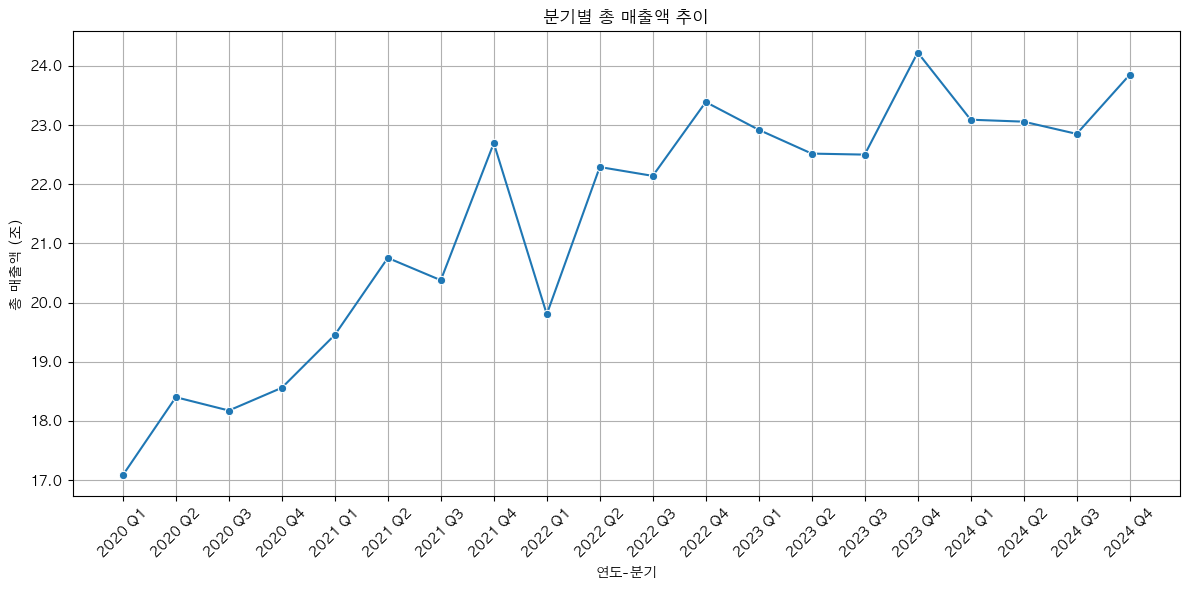

In [4]:
# 'STDR_YYQU_CD'를 문자열로 다루어 연도와 분기를 분리
df['YEAR'] = df['STDR_YYQU_CD'].str[:4]
df['QUARTER'] = df['STDR_YYQU_CD'].str[4:]

# 연도와 분기별 총 매출액 계산
sales_over_time = df.groupby(['YEAR', 'QUARTER'])['THSMON_SELNG_AMT'].sum().reset_index()
sales_over_time['YEAR_QUARTER'] = sales_over_time['YEAR'] + ' Q' + sales_over_time['QUARTER']

plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_over_time, x='YEAR_QUARTER', y='THSMON_SELNG_AMT', marker='o')
plt.title('분기별 총 매출액 추이')
plt.xlabel('연도-분기')
plt.ylabel('총 매출액 (조)')
plt.xticks(rotation=45)
plt.grid(True)

# Y축 단위를 조 단위로 변경
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x/1e12:.1f}"))

plt.tight_layout()
plt.show()

## 2. 상권 유형별 총 매출액

- 발달상권
- 골목상권
- 전통시장
- 관광특구

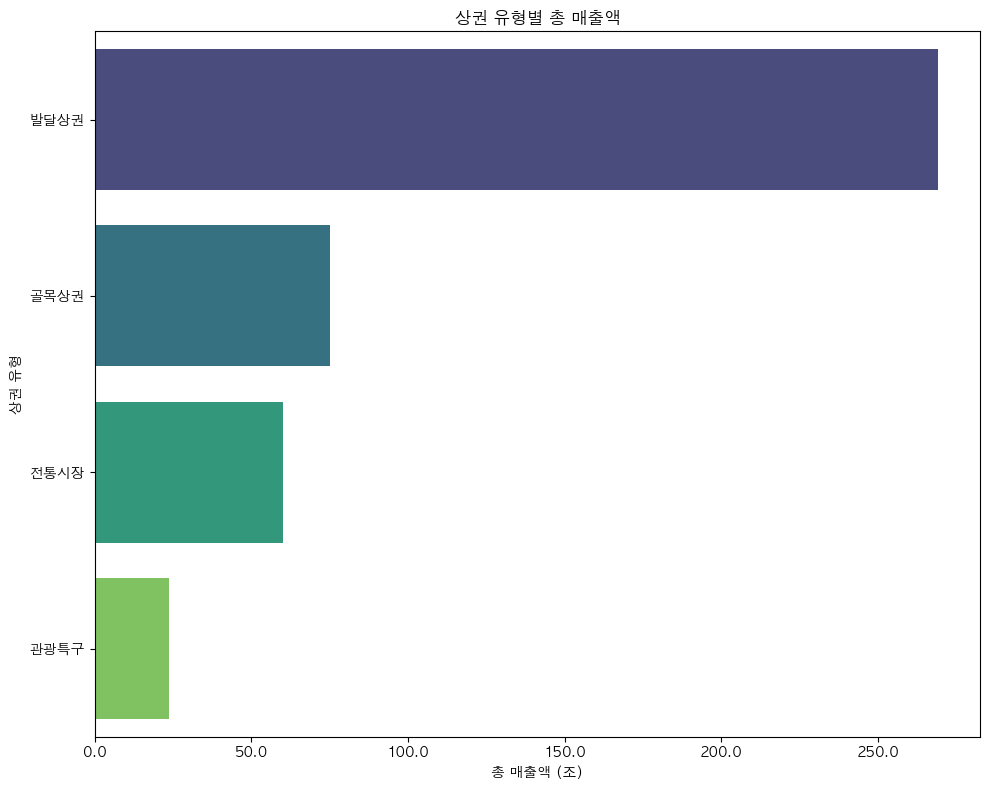

In [5]:
sales_by_district = df.groupby('TRDAR_SE_CD_NM')['THSMON_SELNG_AMT'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=sales_by_district.values,
    y=sales_by_district.index,
    hue= sales_by_district.index,
    palette='viridis',
    legend=False
)
plt.title('상권 유형별 총 매출액')
plt.xlabel('총 매출액 (조)')
plt.ylabel('상권 유형')

# X축 단위를 조 단위로 변경
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x/1e12:.1f}"))

plt.tight_layout()
plt.show()

## 3. 상위 20개 서비스 업종별 총 매출액

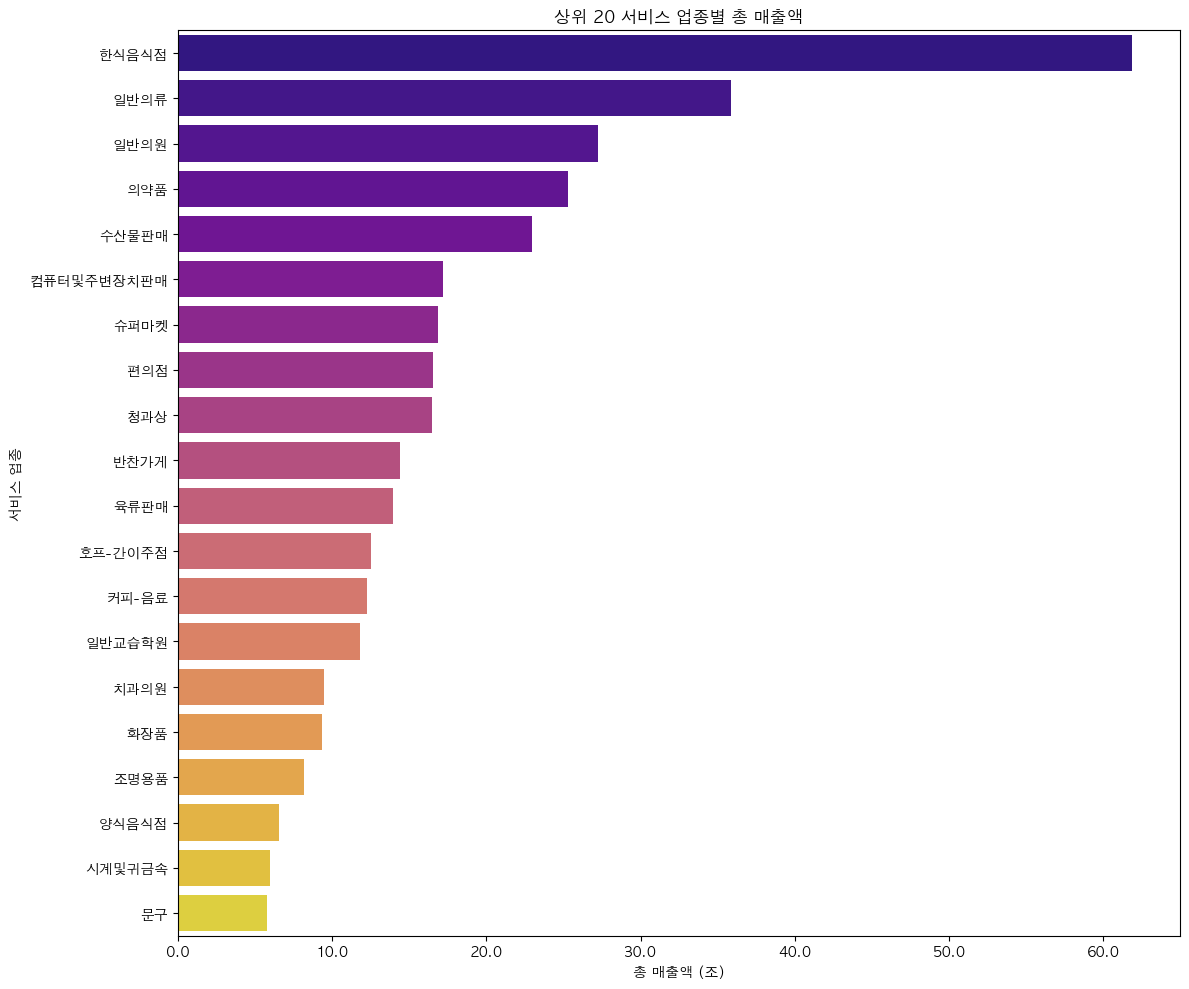

In [6]:
top_n = 20
sales_by_industry = df.groupby('SVC_INDUTY_CD_NM')['THSMON_SELNG_AMT'].sum().sort_values(ascending=False).head(top_n)

plt.figure(figsize=(12, 10))
sns.barplot(
    x=sales_by_industry.values,
    y=sales_by_industry.index,
    hue= sales_by_industry.index,
    palette='plasma',
    legend=False
)
plt.title(f'상위 {top_n} 서비스 업종별 총 매출액')
plt.xlabel('총 매출액 (조)')
plt.ylabel('서비스 업종')

# X축 단위를 조 단위로 변경
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x/1e12:.1f}"))

plt.tight_layout()
plt.show()

## 경제활동가능인구 매출 분석

이제부터 '경제활동가능인구 매출' (20대~60대 이상) 데이터를 활용한 심화 분석을 진행합니다.

In [7]:
import geopandas as gpd
import folium
from folium import Choropleth
import json

# shapefile 로드
shapefile_path = 'data/geo_code/서울시 상권분석서비스(영역-상권).shp'
gdf_districts = gpd.read_file(shapefile_path, encoding='utf-8')

print(f"Shapefile loaded: {len(gdf_districts)} records")
print(f"Columns: {list(gdf_districts.columns)}")

Shapefile loaded: 1650 records
Columns: ['TRDAR_SE_C', 'TRDAR_SE_1', 'TRDAR_CD', 'TRDAR_CD_N', 'XCNTS_VALU', 'YDNTS_VALU', 'SIGNGU_CD', 'SIGNGU_CD_', 'ADSTRD_CD', 'ADSTRD_CD_', 'RELM_AR', 'geometry']


## 1. 행정동별 경제활동가능인구 매출 지도 시각화 (Spatial Visualization)

행정동별로 경제활동가능인구의 매출을 집계하여 서울 지도 위에 시각화합니다.

- 행정동별 경제활동가능인구 매출 집계 완료 -
  ADSTRD_NM  TOTAL_ECNMY_SALES
0      가락1동      6302277536793
1      가락2동       629009361407
2      가락본동      1687254054812
3      가리봉동       322564812011
4       가산동     13541823550875


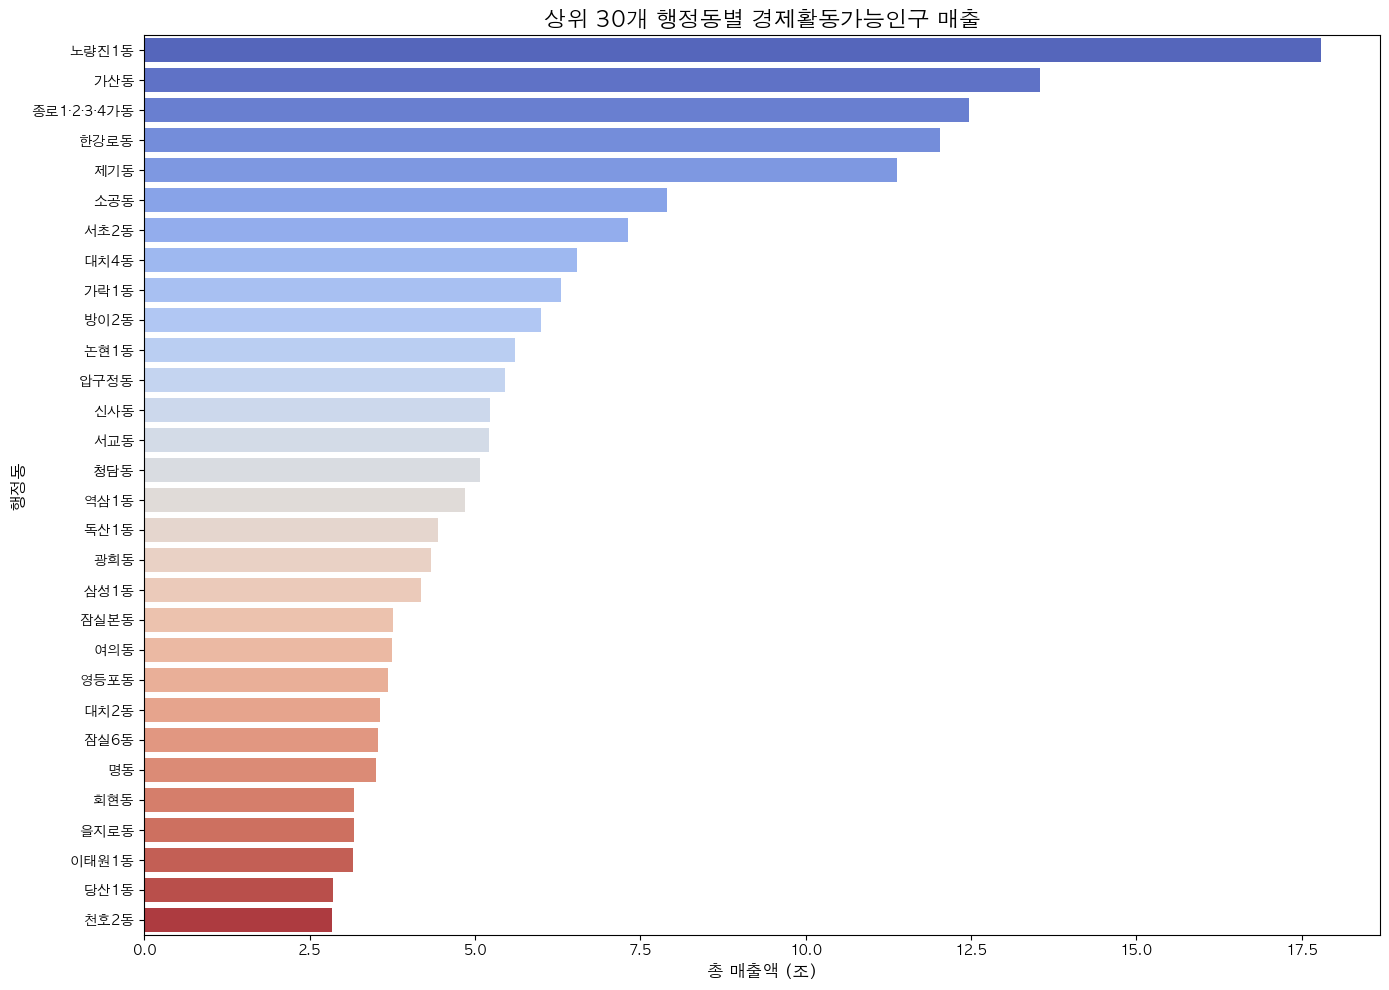


상위 10개 행정동:
       ADSTRD_NM  TOTAL_ECNMY_SALES
52         노량진1동     17792789112898
4            가산동     13541823550875
330  종로1·2·3·4가동     12464143875268
370         한강로동     12023735499188
328          제기동     11378459742334
198          소공동      7898135362839
182         서초2동      7314121734447
70          대치4동      6534362191197
0           가락1동      6302277536793
127         방이2동      5994568755005


In [8]:
# 행정동별 경제활동가능인구 매출 집계
sales_by_adstrd = df.groupby('ADSTRD_NM')['ECNMY_ACTIVE_POP_SELNG_AMT'].sum().reset_index()
sales_by_adstrd.columns = ['ADSTRD_NM', 'TOTAL_ECNMY_SALES']
print("- 행정동별 경제활동가능인구 매출 집계 완료 -")
print(sales_by_adstrd.head())
print("="*10)

# 상위 30개 행정동 시각화
top30_adstrd = sales_by_adstrd.nlargest(30, 'TOTAL_ECNMY_SALES')

plt.figure(figsize=(14, 10))
sns.barplot(
    data=top30_adstrd,
    x='TOTAL_ECNMY_SALES',
    y='ADSTRD_NM',
    hue='ADSTRD_NM',
    palette='coolwarm',
    legend=False
)
plt.title('상위 30개 행정동별 경제활동가능인구 매출', fontsize=16, fontweight='bold')
plt.xlabel('총 매출액 (조)', fontsize=12)
plt.ylabel('행정동', fontsize=12)

# X축 단위를 조 단위로 변경
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x/1e12:.1f}"))

plt.tight_layout()
plt.show()

print(f"\n상위 10개 행정동:")
print(top30_adstrd.head(10))

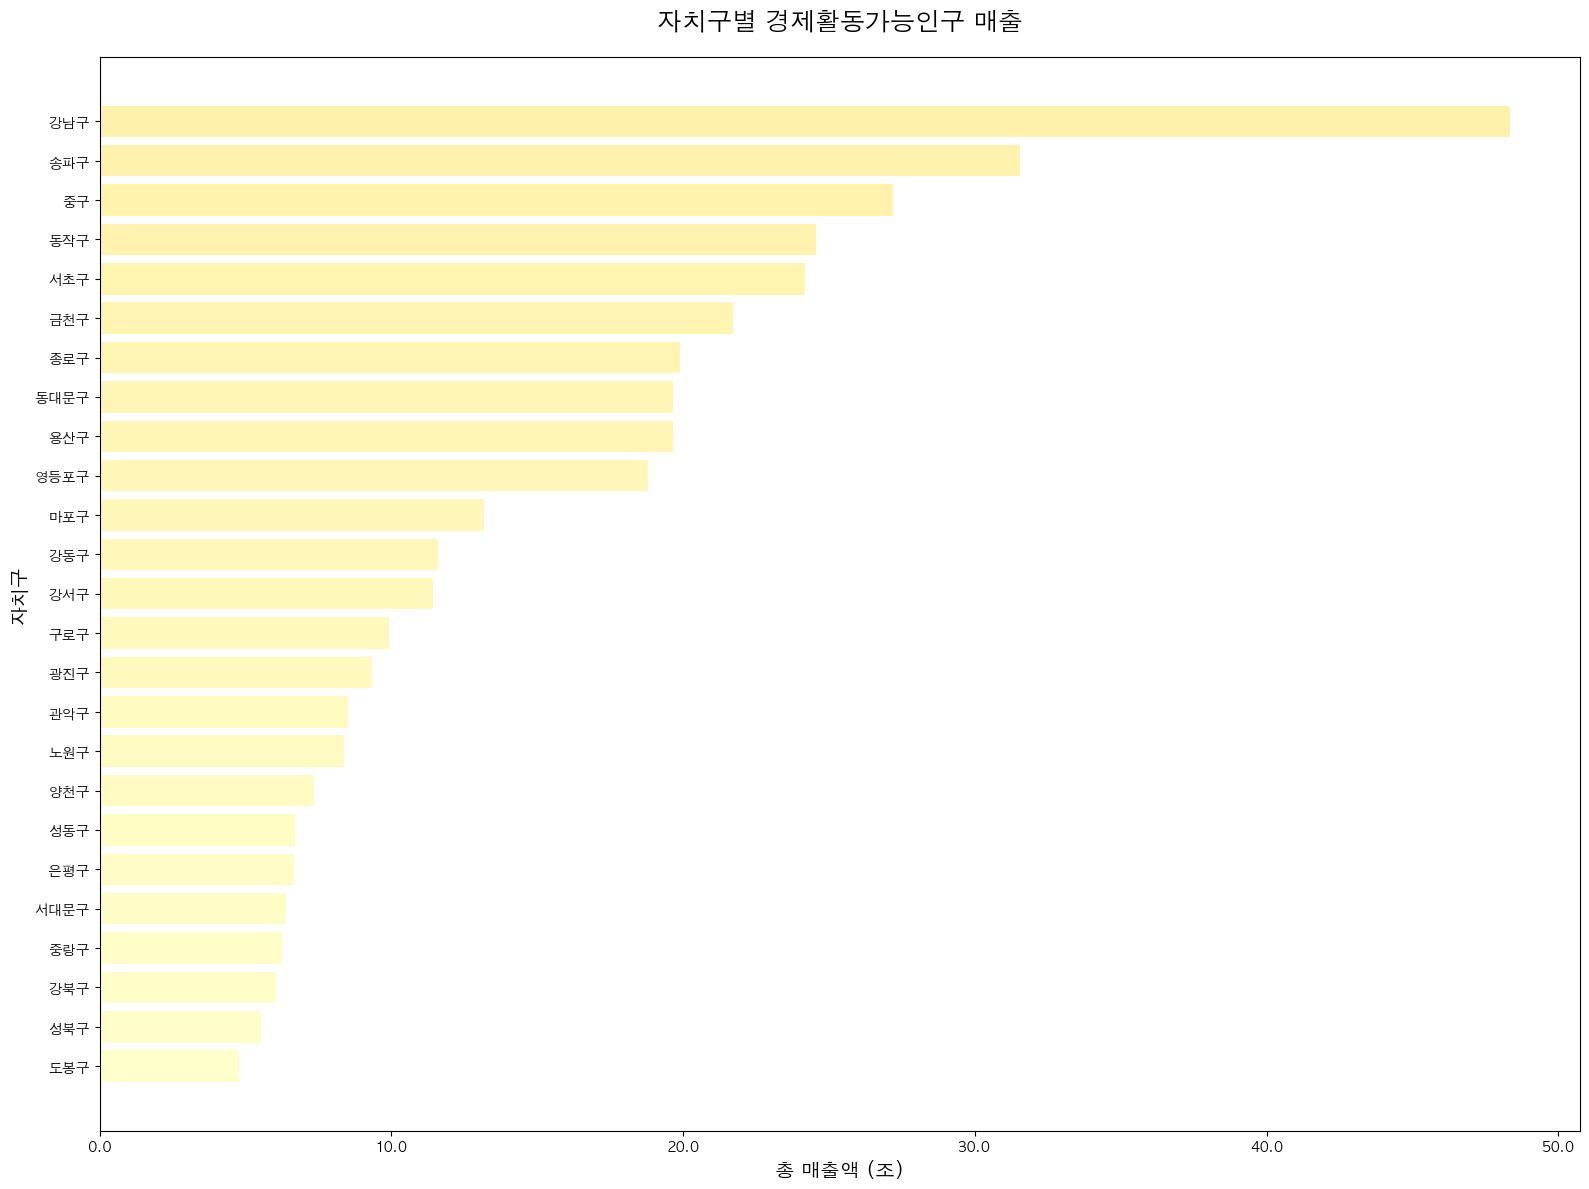


자치구별 경제활동가능인구 매출 순위:
   SIGNGU_NM  TOTAL_ECNMY_SALES
0        강남구     48328539275765
17       송파구     31534351013191
23        중구     27180228660475
11       동작구     24541288096627
14       서초구     24166175535065
7        금천구     21692184144918
22       종로구     19881638707071
10      동대문구     19650879075459
20       용산구     19635204550914
19      영등포구     18785355321127
12       마포구     13161260838013
1        강동구     11601409617210
3        강서구     11428802161443
6        구로구      9916988424005
5        광진구      9347312946641
4        관악구      8503142720919
8        노원구      8377964381326
18       양천구      7330964973178
15       성동구      6683718778569
21       은평구      6658183160867
13      서대문구      6384947546919
24       중랑구      6259377079850
2        강북구      6051612855643
16       성북구      5526892282746
9        도봉구      4787300149980


In [9]:
# Choropleth Map 시각화 (자치구별)
# 자치구별 경제활동가능인구 매출 집계
sales_by_signgu = df.groupby('SIGNGU_NM')['ECNMY_ACTIVE_POP_SELNG_AMT'].sum().reset_index()
sales_by_signgu.columns = ['SIGNGU_NM', 'TOTAL_ECNMY_SALES']

# 지도 시각화
plt.figure(figsize=(16, 12))
sales_by_signgu_sorted = sales_by_signgu.sort_values('TOTAL_ECNMY_SALES', ascending=True)

colors = plt.cm.YlOrRd(range(len(sales_by_signgu_sorted)))

plt.barh(sales_by_signgu_sorted['SIGNGU_NM'], sales_by_signgu_sorted['TOTAL_ECNMY_SALES'], color=colors)
plt.title('자치구별 경제활동가능인구 매출', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('총 매출액 (조)', fontsize=14)
plt.ylabel('자치구', fontsize=14)

# X축 단위를 조 단위로 변경
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x/1e12:.1f}"))

plt.tight_layout()
plt.show()

print("\n자치구별 경제활동가능인구 매출 순위:")
print(sales_by_signgu.sort_values('TOTAL_ECNMY_SALES', ascending=False))

## 2. 행정동별/상권 유형별 경제활동가능인구 매출 시계열 분석 (Time Series Analysis)

특정 행정동과 상권 유형에서 경제활동가능인구 매출이 시간에 따라 어떻게 변화하는지 분석합니다.

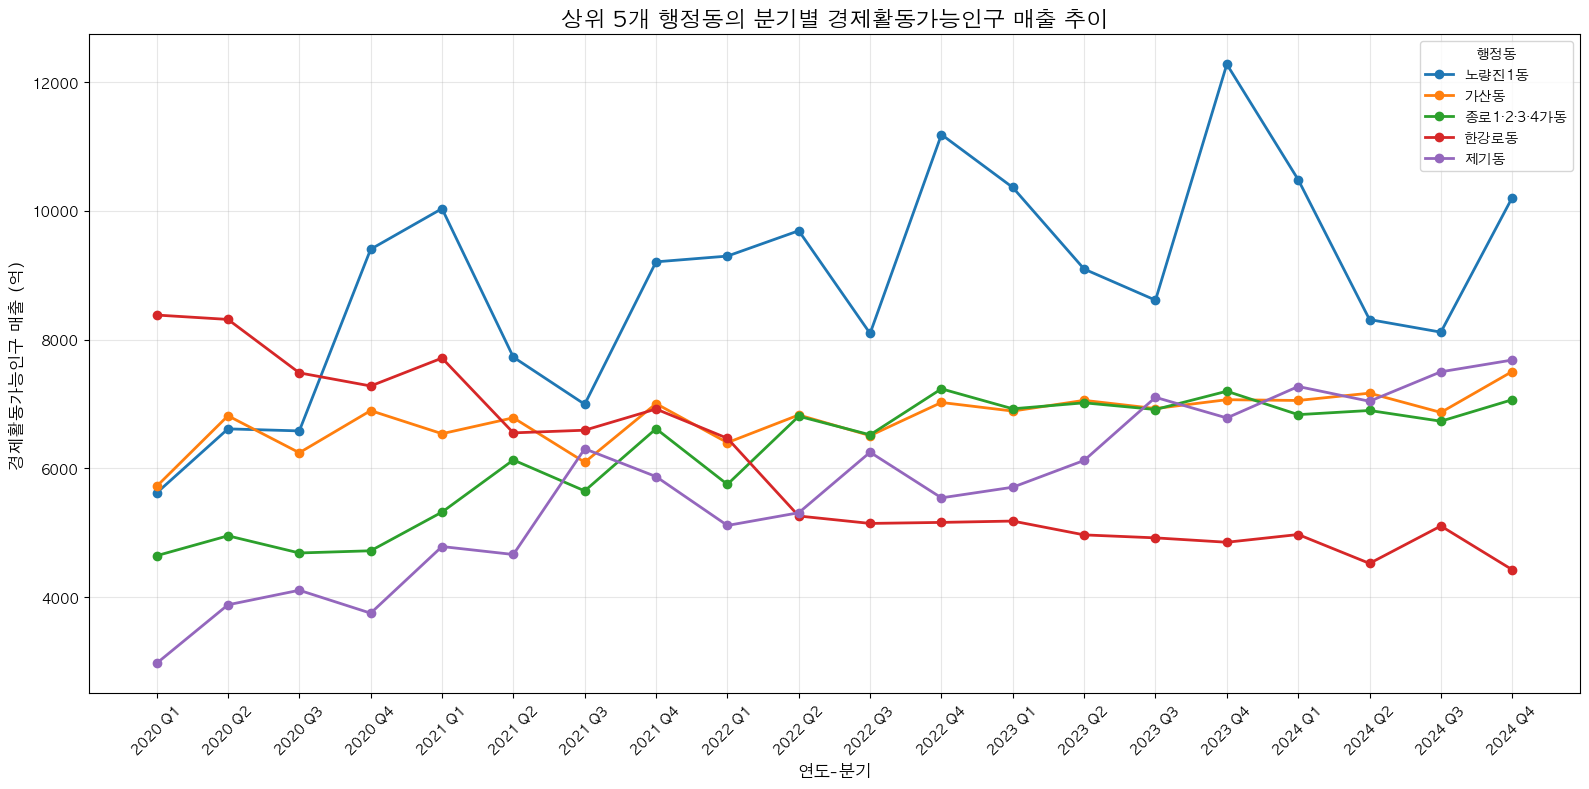

In [10]:
# 상위 5개 행정동의 분기별 경제활동가능인구 매출 추이
top5_adstrd = sales_by_adstrd.nlargest(5, 'TOTAL_ECNMY_SALES')['ADSTRD_NM'].tolist()

timeseries_by_adstrd = df[df['ADSTRD_NM'].isin(top5_adstrd)].groupby(['ADSTRD_NM', 'YEAR', 'QUARTER'])['ECNMY_ACTIVE_POP_SELNG_AMT'].sum().reset_index()
timeseries_by_adstrd['YEAR_QUARTER'] = timeseries_by_adstrd['YEAR'] + ' Q' + timeseries_by_adstrd['QUARTER']

plt.figure(figsize=(16, 8))
for adstrd in top5_adstrd:
    data = timeseries_by_adstrd[timeseries_by_adstrd['ADSTRD_NM'] == adstrd]
    plt.plot(data['YEAR_QUARTER'], data['ECNMY_ACTIVE_POP_SELNG_AMT'], marker='o', label=adstrd, linewidth=2)

plt.title('상위 5개 행정동의 분기별 경제활동가능인구 매출 추이', fontsize=16, fontweight='bold')
plt.xlabel('연도-분기', fontsize=12)
plt.ylabel('경제활동가능인구 매출 (억)', fontsize=12)
plt.legend(title='행정동', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Y축 단위를 억 단위로 변경
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x/1e8:.0f}"))

plt.tight_layout()
plt.show()

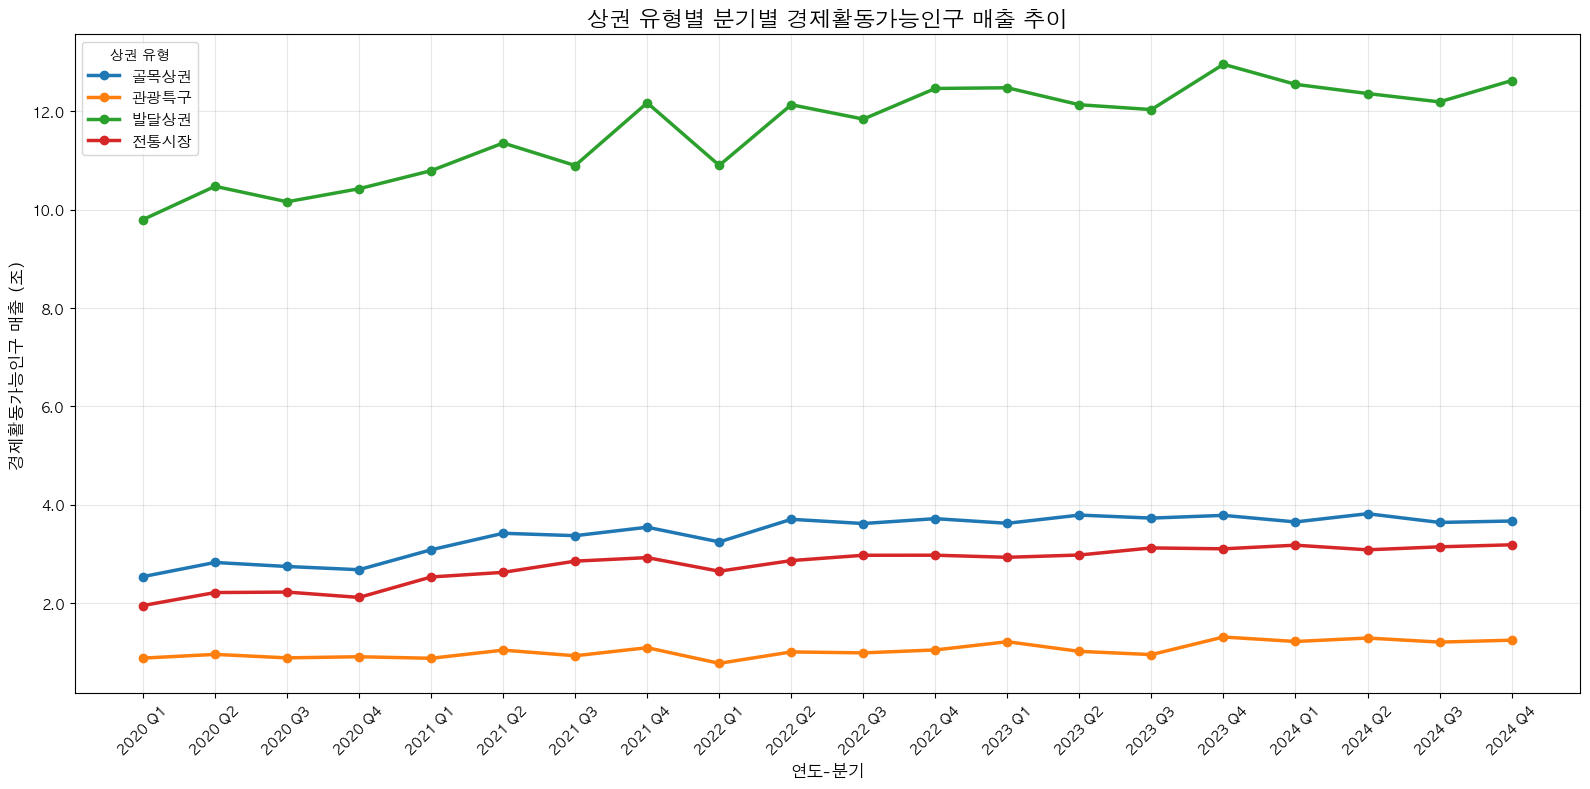

In [11]:
# 상권 유형별 분기별 경제활동가능인구 매출 추이
timeseries_by_trdar = df.groupby(['TRDAR_SE_CD_NM', 'YEAR', 'QUARTER'])['ECNMY_ACTIVE_POP_SELNG_AMT'].sum().reset_index()
timeseries_by_trdar['YEAR_QUARTER'] = timeseries_by_trdar['YEAR'] + ' Q' + timeseries_by_trdar['QUARTER']

plt.figure(figsize=(16, 8))
for trdar_type in timeseries_by_trdar['TRDAR_SE_CD_NM'].unique():
    data = timeseries_by_trdar[timeseries_by_trdar['TRDAR_SE_CD_NM'] == trdar_type]
    plt.plot(data['YEAR_QUARTER'], data['ECNMY_ACTIVE_POP_SELNG_AMT'], marker='o', label=trdar_type, linewidth=2.5)

plt.title('상권 유형별 분기별 경제활동가능인구 매출 추이', fontsize=16, fontweight='bold')
plt.xlabel('연도-분기', fontsize=12)
plt.ylabel('경제활동가능인구 매출 (조)', fontsize=12)
plt.legend(title='상권 유형', fontsize=11)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Y축 단위를 조 단위로 변경
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x/1e12:.1f}"))

plt.tight_layout()
plt.show()

## 3. 상권 유형별 경제활동가능인구 매출 비중 분석 (Proportional Analysis)

전체 매출액 대비 경제활동가능인구 매출이 차지하는 비중을 상권 유형별로 비교합니다.

/var/folders/rv/2m7fs5ls63jgc4gpfkbwd6lm0000gn/T/ipykernel_93497/4091448497.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(proportional_analysis['TRDAR_SE_CD_NM'], rotation=15)


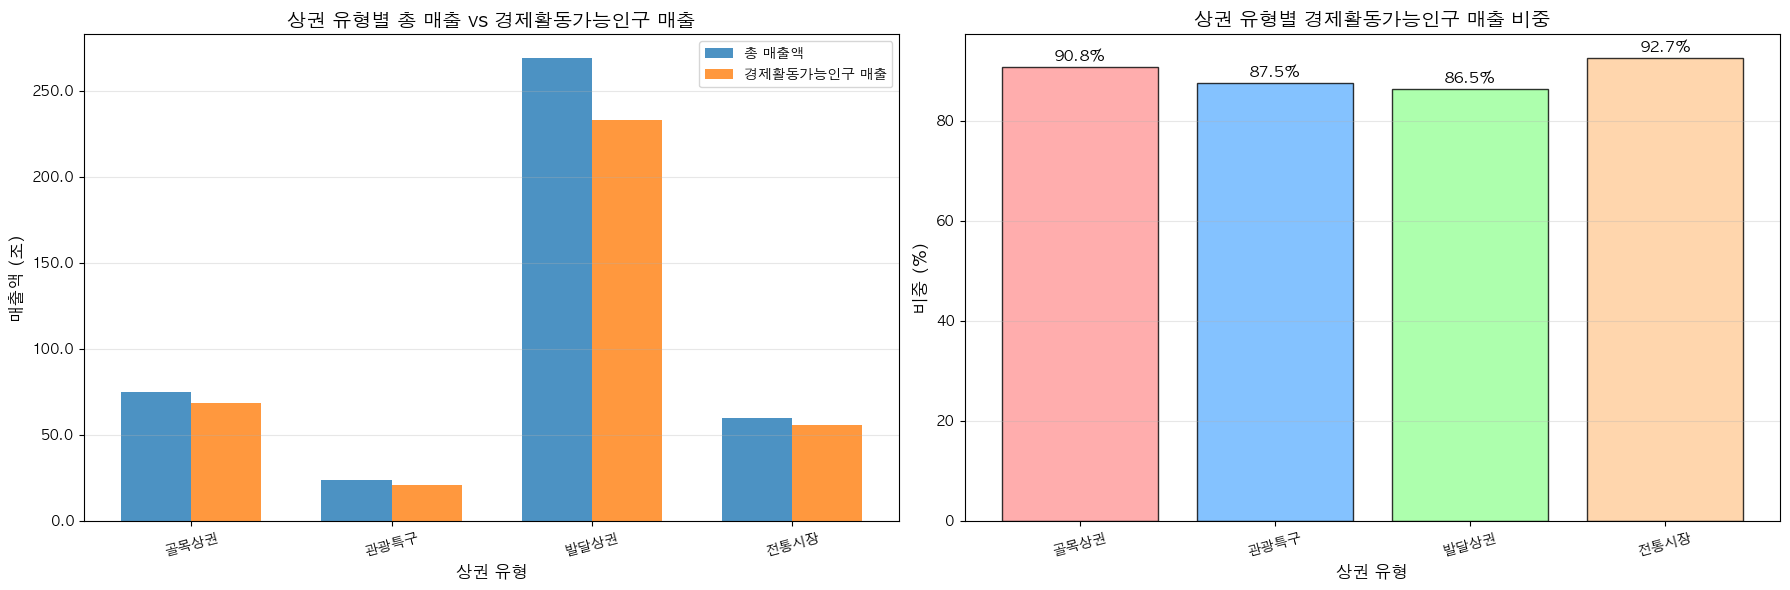


상권 유형별 경제활동가능인구 매출 비중:
  TRDAR_SE_CD_NM  THSMON_SELNG_AMT  ECNMY_ACTIVE_POP_SELNG_AMT  ECNMY_RATIO
3           전통시장    60001928020555              55614943060440    92.688593
0           골목상권    75110881949718              68184318861884    90.778216
1           관광특구    23805828947626              20838639942382    87.535872
2           발달상권   269212173040588             232777820433215    86.466306


In [12]:
# 상권 유형별 총 매출과 경제활동가능인구 매출 집계
proportional_analysis = df.groupby('TRDAR_SE_CD_NM').agg({
    'THSMON_SELNG_AMT': 'sum',
    'ECNMY_ACTIVE_POP_SELNG_AMT': 'sum'
}).reset_index()

# 비율 계산
proportional_analysis['ECNMY_RATIO'] = (proportional_analysis['ECNMY_ACTIVE_POP_SELNG_AMT'] / proportional_analysis['THSMON_SELNG_AMT']) * 100

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 왼쪽 차트: 총 매출 vs 경제활동가능인구 매출
x = range(len(proportional_analysis))
width = 0.35

axes[0].bar([i - width/2 for i in x], proportional_analysis['THSMON_SELNG_AMT'], width, label='총 매출액', alpha=0.8)
axes[0].bar([i + width/2 for i in x], proportional_analysis['ECNMY_ACTIVE_POP_SELNG_AMT'], width, label='경제활동가능인구 매출', alpha=0.8)

axes[0].set_xlabel('상권 유형', fontsize=12)
axes[0].set_ylabel('매출액 (조)', fontsize=12)
axes[0].set_title('상권 유형별 총 매출 vs 경제활동가능인구 매출', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(proportional_analysis['TRDAR_SE_CD_NM'], rotation=15)
axes[0].legend()
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, loc: f"{y/1e12:.1f}"))
axes[0].grid(True, alpha=0.3, axis='y')

# 오른쪽 차트: 비중(%)
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
axes[1].bar(proportional_analysis['TRDAR_SE_CD_NM'], proportional_analysis['ECNMY_RATIO'], color=colors, alpha=0.8, edgecolor='black')

axes[1].set_xlabel('상권 유형', fontsize=12)
axes[1].set_ylabel('비중 (%)', fontsize=12)
axes[1].set_title('상권 유형별 경제활동가능인구 매출 비중', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(proportional_analysis['TRDAR_SE_CD_NM'], rotation=15)
axes[1].grid(True, alpha=0.3, axis='y')

# 비율 라벨 추가
for i, (trdar, ratio) in enumerate(zip(proportional_analysis['TRDAR_SE_CD_NM'], proportional_analysis['ECNMY_RATIO'])):
    axes[1].text(i, ratio + 0.5, f'{ratio:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n상권 유형별 경제활동가능인구 매출 비중:")
print(proportional_analysis.sort_values('ECNMY_RATIO', ascending=False))

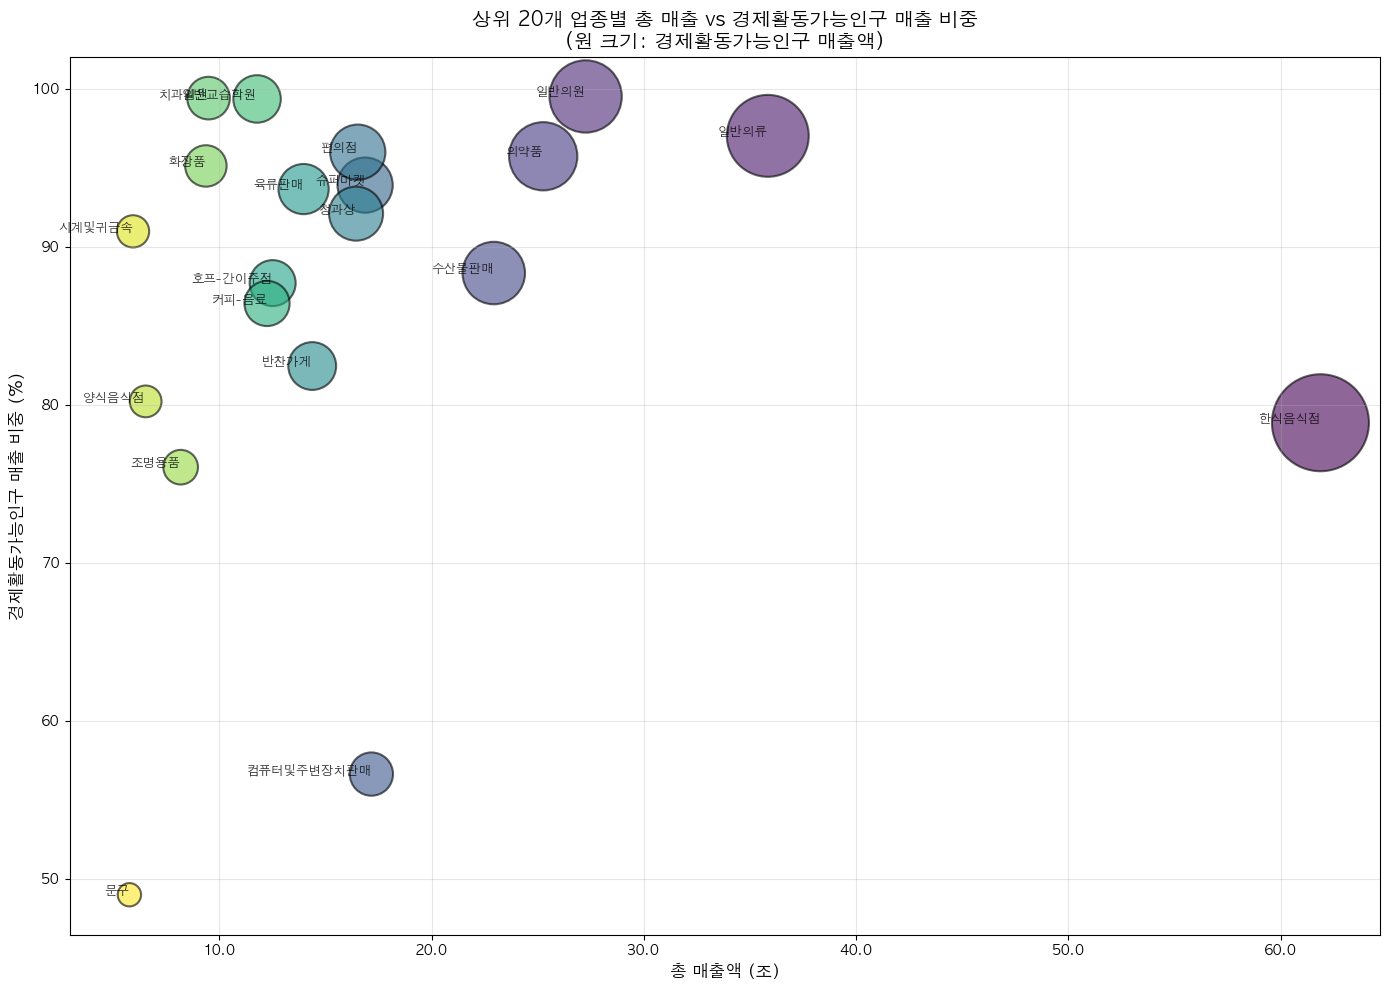


상위 20개 업종의 경제활동가능인구 매출 비중:
   SVC_INDUTY_CD_NM  ECNMY_RATIO
39             일반의원    99.521936
50             치과의원    99.416524
37           일반교습학원    99.365306
38             일반의류    97.028611
55              편의점    95.992178
35              의약품    95.734471
61              화장품    95.122128
20             슈퍼마켓    93.909252
33             육류판매    93.658639
49              청과상    92.102209
23           시계및귀금속    90.981216
19            수산물판매    88.342268
60          호프-간이주점    87.704215
52            커피-음료    86.414469
13             반찬가게    82.454979
27            양식음식점    80.215801
57            한식음식점    78.864016
46             조명용품    76.050296
53       컴퓨터및주변장치판매    56.620511
10               문구    48.980816


In [13]:
# 업종별 경제활동가능인구 매출 비중 (상위 20개)
proportional_by_industry = df.groupby('SVC_INDUTY_CD_NM').agg({
    'THSMON_SELNG_AMT': 'sum',
    'ECNMY_ACTIVE_POP_SELNG_AMT': 'sum'
}).reset_index()

proportional_by_industry['ECNMY_RATIO'] = (proportional_by_industry['ECNMY_ACTIVE_POP_SELNG_AMT'] / proportional_by_industry['THSMON_SELNG_AMT']) * 100

# 총 매출 상위 20개 업종
top20_industries = proportional_by_industry.nlargest(20, 'THSMON_SELNG_AMT')

plt.figure(figsize=(14, 10))
plt.scatter(top20_industries['THSMON_SELNG_AMT'], top20_industries['ECNMY_RATIO'], 
            s=top20_industries['ECNMY_ACTIVE_POP_SELNG_AMT']/1e10, 
            alpha=0.6, c=range(len(top20_industries)), cmap='viridis', edgecolors='black', linewidth=1.5)

# 업종명 레이블 추가
for idx, row in top20_industries.iterrows():
    plt.annotate(row['SVC_INDUTY_CD_NM'], 
                 (row['THSMON_SELNG_AMT'], row['ECNMY_RATIO']),
                 fontsize=9, ha='right', alpha=0.8)

plt.title('상위 20개 업종별 총 매출 vs 경제활동가능인구 매출 비중\n(원 크기: 경제활동가능인구 매출액)', 
          fontsize=14, fontweight='bold')
plt.xlabel('총 매출액 (조)', fontsize=12)
plt.ylabel('경제활동가능인구 매출 비중 (%)', fontsize=12)
plt.grid(True, alpha=0.3)

# X축 단위를 조 단위로 변경
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x/1e12:.1f}"))

plt.tight_layout()
plt.show()

print("\n상위 20개 업종의 경제활동가능인구 매출 비중:")
print(top20_industries[['SVC_INDUTY_CD_NM', 'ECNMY_RATIO']].sort_values('ECNMY_RATIO', ascending=False))

## 연도별 지역별 매출 분석

연도별로 지역(자치구/행정동)의 매출 변화를 분석합니다.

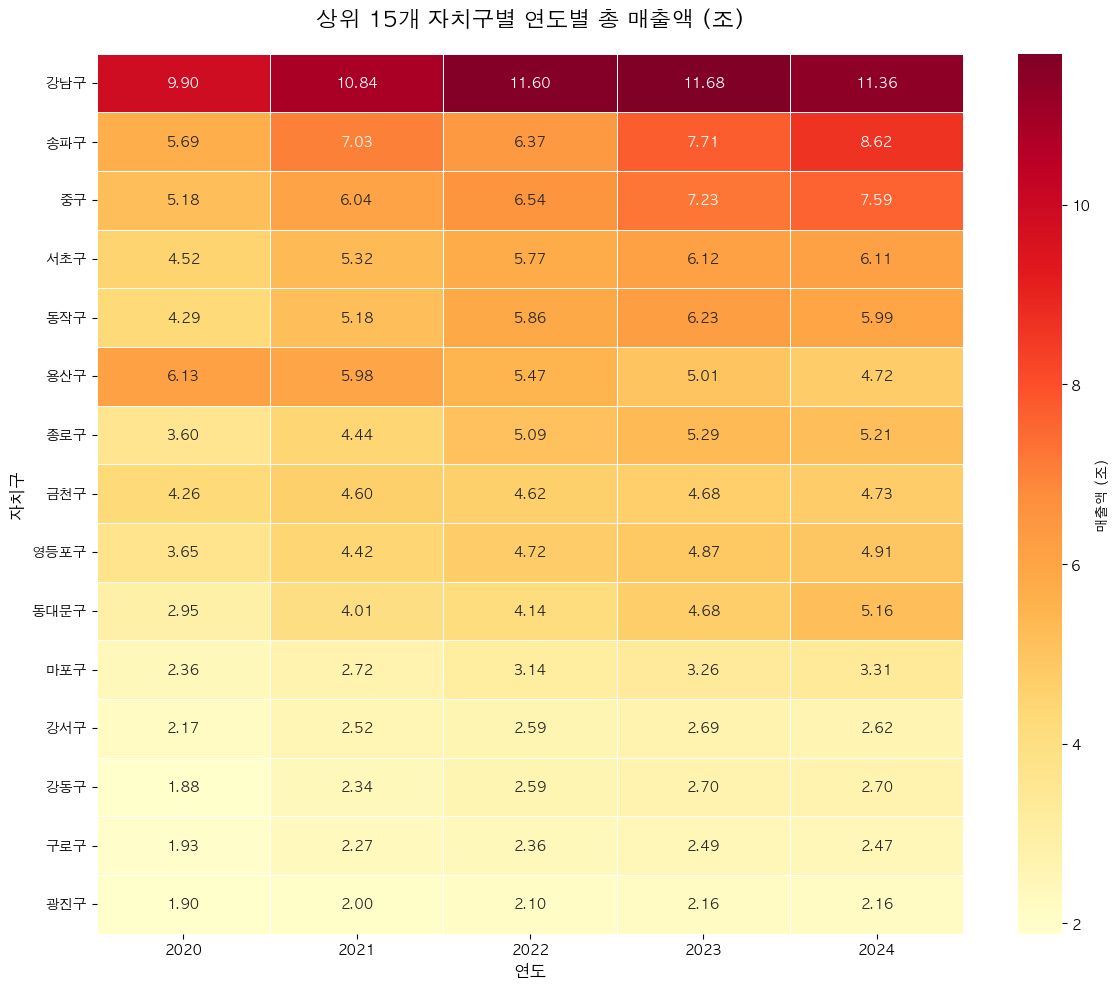


자치구별 연도별 총 매출액 (조):
YEAR           2020       2021       2022       2023       2024
SIGNGU_NM                                                      
강남구        9.904933  10.835668  11.599195  11.680353  11.361241
송파구        5.693914   7.026072   6.365196   7.713033   8.619555
중구         5.176280   6.043899   6.540237   7.233500   7.594643
서초구        4.515589   5.323970   5.772621   6.124709   6.108151
동작구        4.288505   5.184047   5.860118   6.232778   5.985803
용산구        6.130180   5.976394   5.469643   5.010507   4.724787
종로구        3.600467   4.437750   5.088821   5.293344   5.212153
금천구        4.260723   4.603754   4.624373   4.675459   4.734736
영등포구       3.646198   4.422101   4.724302   4.870937   4.912937
동대문구       2.948813   4.008484   4.141399   4.682685   5.157409
마포구        2.358114   2.721555   3.142602   3.264135   3.310788
강서구        2.172271   2.524512   2.592296   2.693777   2.620799
강동구        1.883926   2.344380   2.590492   2.704589   2.700684
구로구        1.925116

In [14]:
# 자치구별 연도별 총 매출 집계
sales_by_signgu_year = df.groupby(['SIGNGU_NM', 'YEAR'])['THSMON_SELNG_AMT'].sum().reset_index()

# 피벗 테이블로 변환 (행: 자치구, 열: 연도)
sales_pivot = sales_by_signgu_year.pivot(index='SIGNGU_NM', columns='YEAR', values='THSMON_SELNG_AMT')

# 총 매출 기준으로 상위 15개 자치구 선택
top15_signgu = sales_pivot.sum(axis=1).nlargest(15).index
sales_pivot_top15 = sales_pivot.loc[top15_signgu]

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(sales_pivot_top15 / 1e12, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': '매출액 (조)'}, linewidths=0.5)
plt.title('상위 15개 자치구별 연도별 총 매출액 (조)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('연도', fontsize=12)
plt.ylabel('자치구', fontsize=12)
plt.tight_layout()
plt.show()

print("\n자치구별 연도별 총 매출액 (조):")
print(sales_pivot_top15 / 1e12)

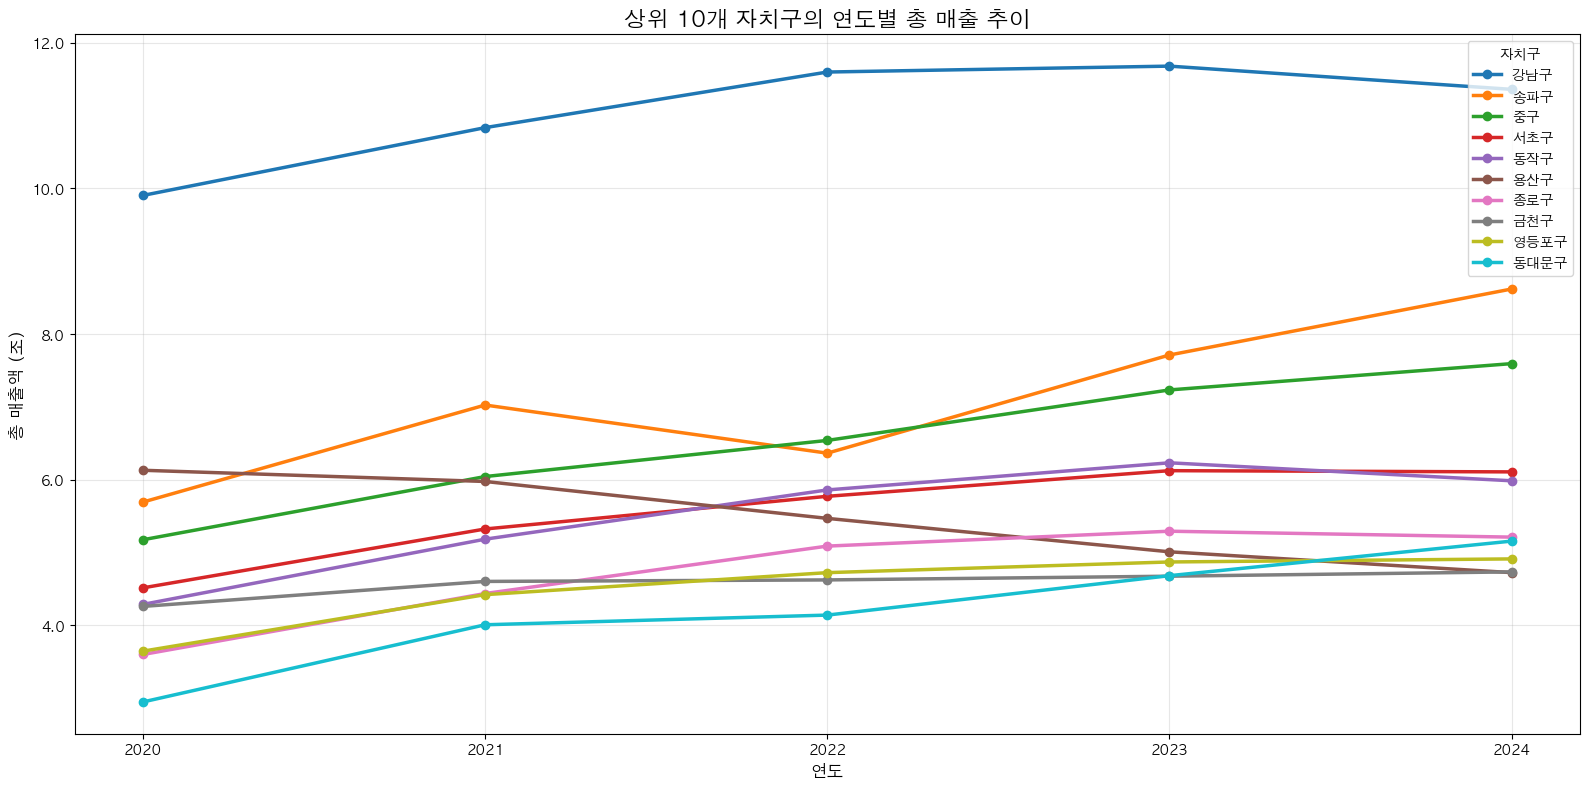

In [15]:
# 상위 10개 자치구의 연도별 매출 추이
top10_signgu_list = sales_pivot.sum(axis=1).nlargest(10).index

plt.figure(figsize=(16, 8))
for signgu in top10_signgu_list:
    data = sales_by_signgu_year[sales_by_signgu_year['SIGNGU_NM'] == signgu]
    plt.plot(data['YEAR'], data['THSMON_SELNG_AMT'], marker='o', label=signgu, linewidth=2.5)

plt.title('상위 10개 자치구의 연도별 총 매출 추이', fontsize=16, fontweight='bold')
plt.xlabel('연도', fontsize=12)
plt.ylabel('총 매출액 (조)', fontsize=12)
plt.legend(title='자치구', fontsize=10, loc='best')
plt.grid(True, alpha=0.3)

# Y축 단위를 조 단위로 변경
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x/1e12:.1f}"))

plt.tight_layout()
plt.show()

### 행정동별 연도별 매출 분석

상위 행정동들의 연도별 매출 변화를 확인합니다.

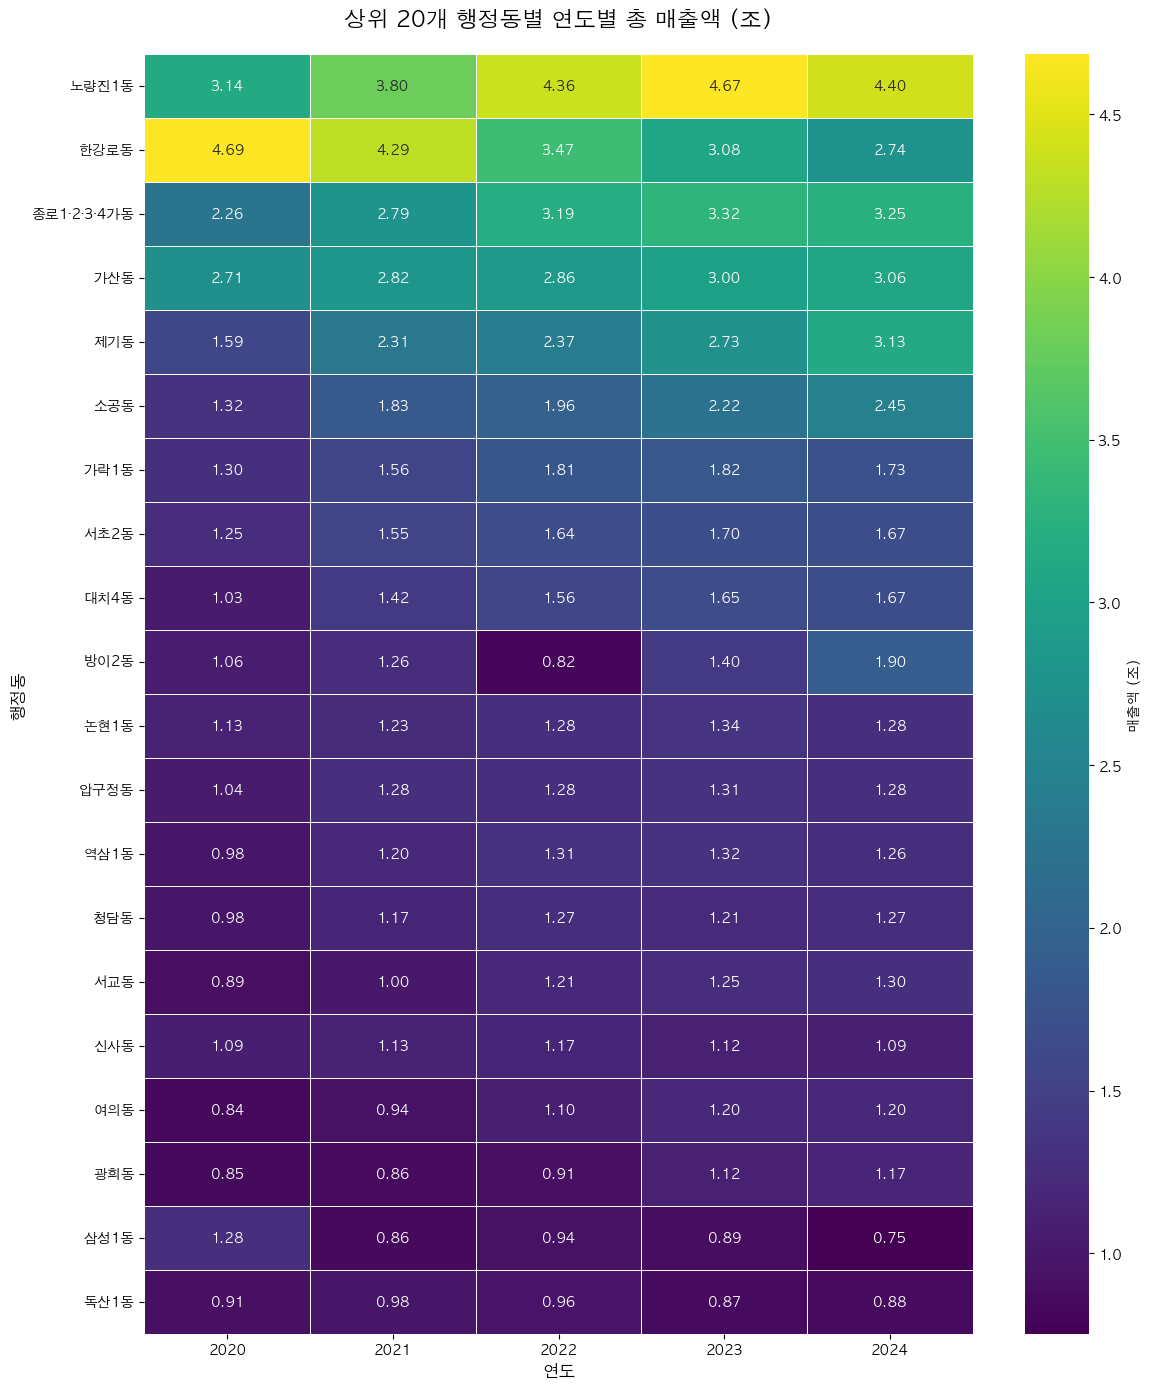


행정동별 연도별 총 매출액 (조):
YEAR             2020      2021      2022      2023      2024
ADSTRD_NM                                                    
노량진1동        3.141484  3.799087  4.364940  4.672144  4.404769
한강로동         4.686193  4.290021  3.468389  3.078461  2.740052
종로1·2·3·4가동  2.263374  2.788881  3.190204  3.316057  3.248972
가산동          2.710186  2.824656  2.863411  2.997502  3.059982
제기동          1.585932  2.306601  2.371086  2.726352  3.125627
소공동          1.318838  1.833759  1.958263  2.223093  2.449704
가락1동         1.303988  1.556135  1.808760  1.815730  1.726507
서초2동         1.250677  1.547846  1.644460  1.697301  1.673141
대치4동         1.034520  1.423205  1.561521  1.648402  1.669776
방이2동         1.058510  1.257187  0.821078  1.401607  1.904559
논현1동         1.126992  1.231049  1.276475  1.338795  1.276460
압구정동         1.040450  1.280585  1.281383  1.309220  1.283408
역삼1동         0.978499  1.197630  1.314398  1.321079  1.262326
청담동          0.982606  1.174288  1.266812  1.2147

In [16]:
# 행정동별 연도별 총 매출 집계
sales_by_adstrd_year = df.groupby(['ADSTRD_NM', 'YEAR'])['THSMON_SELNG_AMT'].sum().reset_index()

# 피벗 테이블로 변환
sales_adstrd_pivot = sales_by_adstrd_year.pivot(index='ADSTRD_NM', columns='YEAR', values='THSMON_SELNG_AMT')

# 총 매출 기준으로 상위 20개 행정동 선택
top20_adstrd_list = sales_adstrd_pivot.sum(axis=1).nlargest(20).index
sales_adstrd_pivot_top20 = sales_adstrd_pivot.loc[top20_adstrd_list]

# 히트맵 시각화
plt.figure(figsize=(12, 14))
sns.heatmap(sales_adstrd_pivot_top20 / 1e12, annot=True, fmt='.2f', cmap='viridis', 
            cbar_kws={'label': '매출액 (조)'}, linewidths=0.5)
plt.title('상위 20개 행정동별 연도별 총 매출액 (조)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('연도', fontsize=12)
plt.ylabel('행정동', fontsize=12)
plt.tight_layout()
plt.show()

print("\n행정동별 연도별 총 매출액 (조):")
print(sales_adstrd_pivot_top20 / 1e12)

### 연도별 매출 증감률 분석

자치구별로 전년 대비 매출 증감률을 확인합니다.

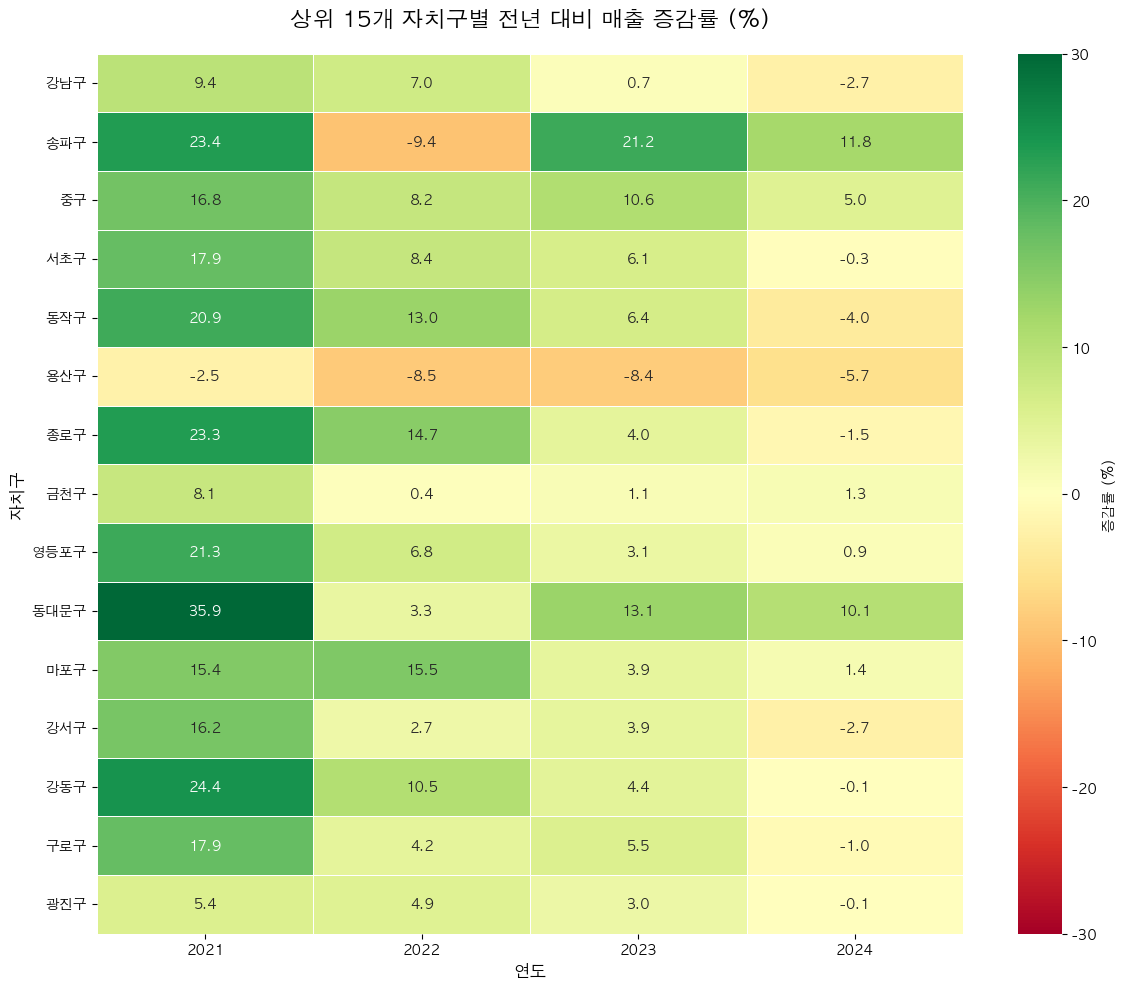


자치구별 연도별 매출 증감률 (%):
YEAR            2021       2022       2023       2024
SIGNGU_NM                                            
강남구         9.396682   7.046426   0.699684  -2.732045
송파구        23.396180  -9.406048  21.175104  11.753116
중구         16.761438   8.212217  10.599964   4.992652
서초구        17.901990   8.427010   6.099267  -0.270354
동작구        20.882369  13.041384   6.359246  -3.962518
용산구        -2.508684  -8.479200  -8.394264  -5.702422
종로구        23.254835  14.671183   4.019075  -1.533835
금천구         8.050996   0.447881   1.104703   1.267847
영등포구       21.279780   6.833882   3.103850   0.862252
동대문구       35.935527   3.315827  13.070128  10.137868
마포구        15.412372  15.470816   3.867271   1.429264
강서구        16.215344   2.685048   3.914706  -2.709125
강동구        24.441171  10.497956   4.404444  -0.144372
구로구        17.851442   4.187702   5.476764  -0.990998
광진구         5.439857   4.947560   2.951420  -0.118282


In [17]:
# 자치구별 연도별 매출 증감률 계산
sales_pivot_pct = sales_pivot_top15.pct_change(axis=1) * 100

# 2021년 이후 증감률만 표시 (2020년은 기준이 없으므로 제외)
sales_pivot_pct = sales_pivot_pct.iloc[:, 1:]

plt.figure(figsize=(12, 10))
sns.heatmap(sales_pivot_pct, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            cbar_kws={'label': '증감률 (%)'}, linewidths=0.5, vmin=-30, vmax=30)
plt.title('상위 15개 자치구별 전년 대비 매출 증감률 (%)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('연도', fontsize=12)
plt.ylabel('자치구', fontsize=12)
plt.tight_layout()
plt.show()

print("\n자치구별 연도별 매출 증감률 (%):")
print(sales_pivot_pct)

### 경제활동가능인구 매출의 연도별 자치구 분석

경제활동가능인구(20대~60대 이상) 매출의 연도별 자치구 변화를 확인합니다.

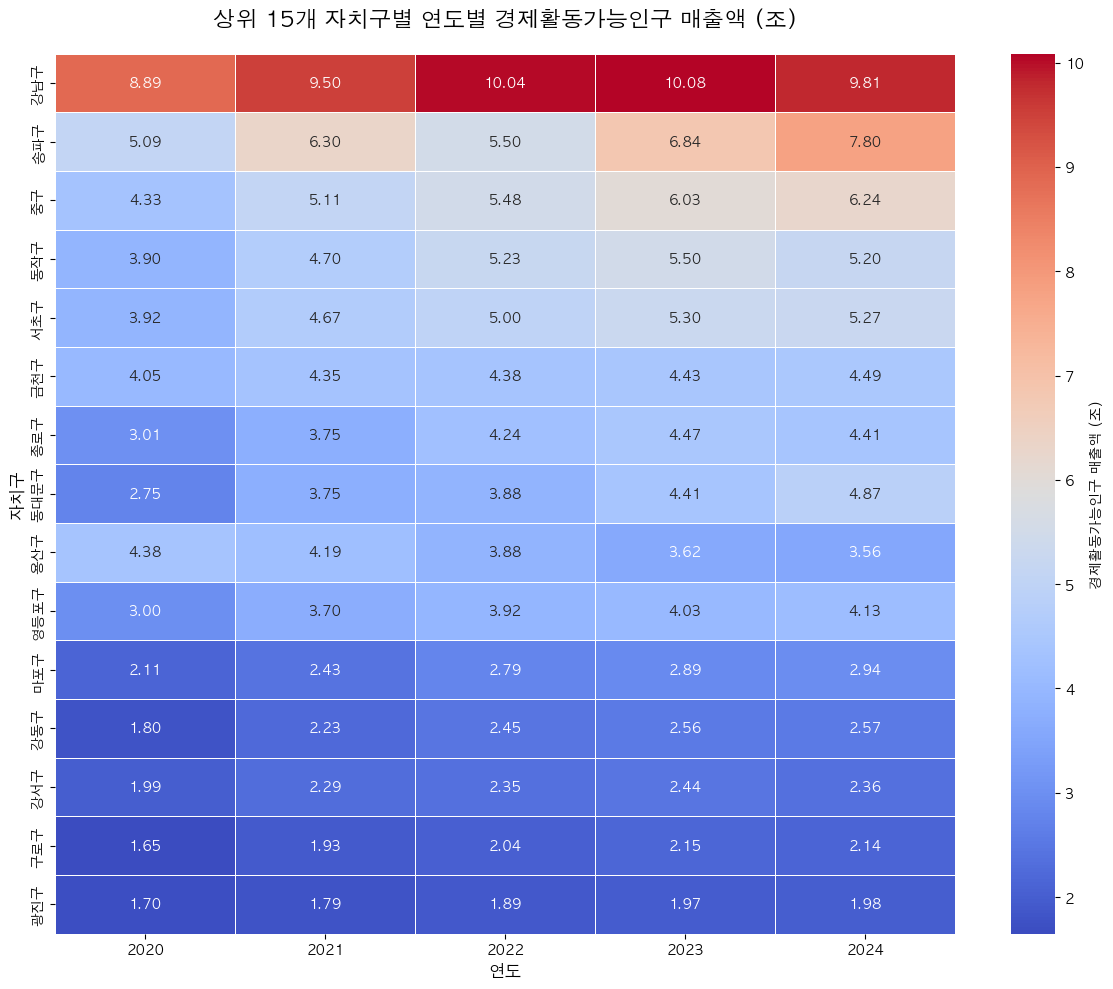


자치구별 연도별 경제활동가능인구 매출액 (조):
YEAR           2020      2021       2022       2023      2024
SIGNGU_NM                                                    
강남구        8.894321  9.503063  10.039974  10.084195  9.806986
송파구        5.085316  6.302761   5.504452   6.838613  7.803209
중구         4.328827  5.106602   5.479322   6.028099  6.237380
동작구        3.903141  4.704188   5.230264   5.499811  5.203883
서초구        3.921364  4.673457   5.004506   5.299696  5.267152
금천구        4.050140  4.348371   4.380078   4.426289  4.487306
종로구        3.005184  3.749591   4.242851   4.469030  4.414983
동대문구       2.745155  3.751861   3.875487   4.410099  4.868278
용산구        4.380290  4.193214   3.882176   3.619758  3.559767
영등포구       2.999282  3.699399   3.924946   4.034206  4.127521
마포구        2.114263  2.426486   2.792776   2.885994  2.941742
강동구        1.796371  2.226629   2.448790   2.561401  2.568218
강서구        1.988862  2.290374   2.347934   2.441782  2.359850
구로구        1.649186  1.933880   2.044140  

In [18]:
# 자치구별 연도별 경제활동가능인구 매출 집계
ecnmy_sales_by_signgu_year = df.groupby(['SIGNGU_NM', 'YEAR'])['ECNMY_ACTIVE_POP_SELNG_AMT'].sum().reset_index()

# 피벗 테이블로 변환
ecnmy_sales_pivot = ecnmy_sales_by_signgu_year.pivot(index='SIGNGU_NM', columns='YEAR', values='ECNMY_ACTIVE_POP_SELNG_AMT')

# 총 매출 기준으로 상위 15개 자치구 선택
top15_signgu_ecnmy = ecnmy_sales_pivot.sum(axis=1).nlargest(15).index
ecnmy_sales_pivot_top15 = ecnmy_sales_pivot.loc[top15_signgu_ecnmy]

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(ecnmy_sales_pivot_top15 / 1e12, annot=True, fmt='.2f', cmap='coolwarm', 
            cbar_kws={'label': '경제활동가능인구 매출액 (조)'}, linewidths=0.5)
plt.title('상위 15개 자치구별 연도별 경제활동가능인구 매출액 (조)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('연도', fontsize=12)
plt.ylabel('자치구', fontsize=12)
plt.tight_layout()
plt.show()

print("\n자치구별 연도별 경제활동가능인구 매출액 (조):")
print(ecnmy_sales_pivot_top15 / 1e12)

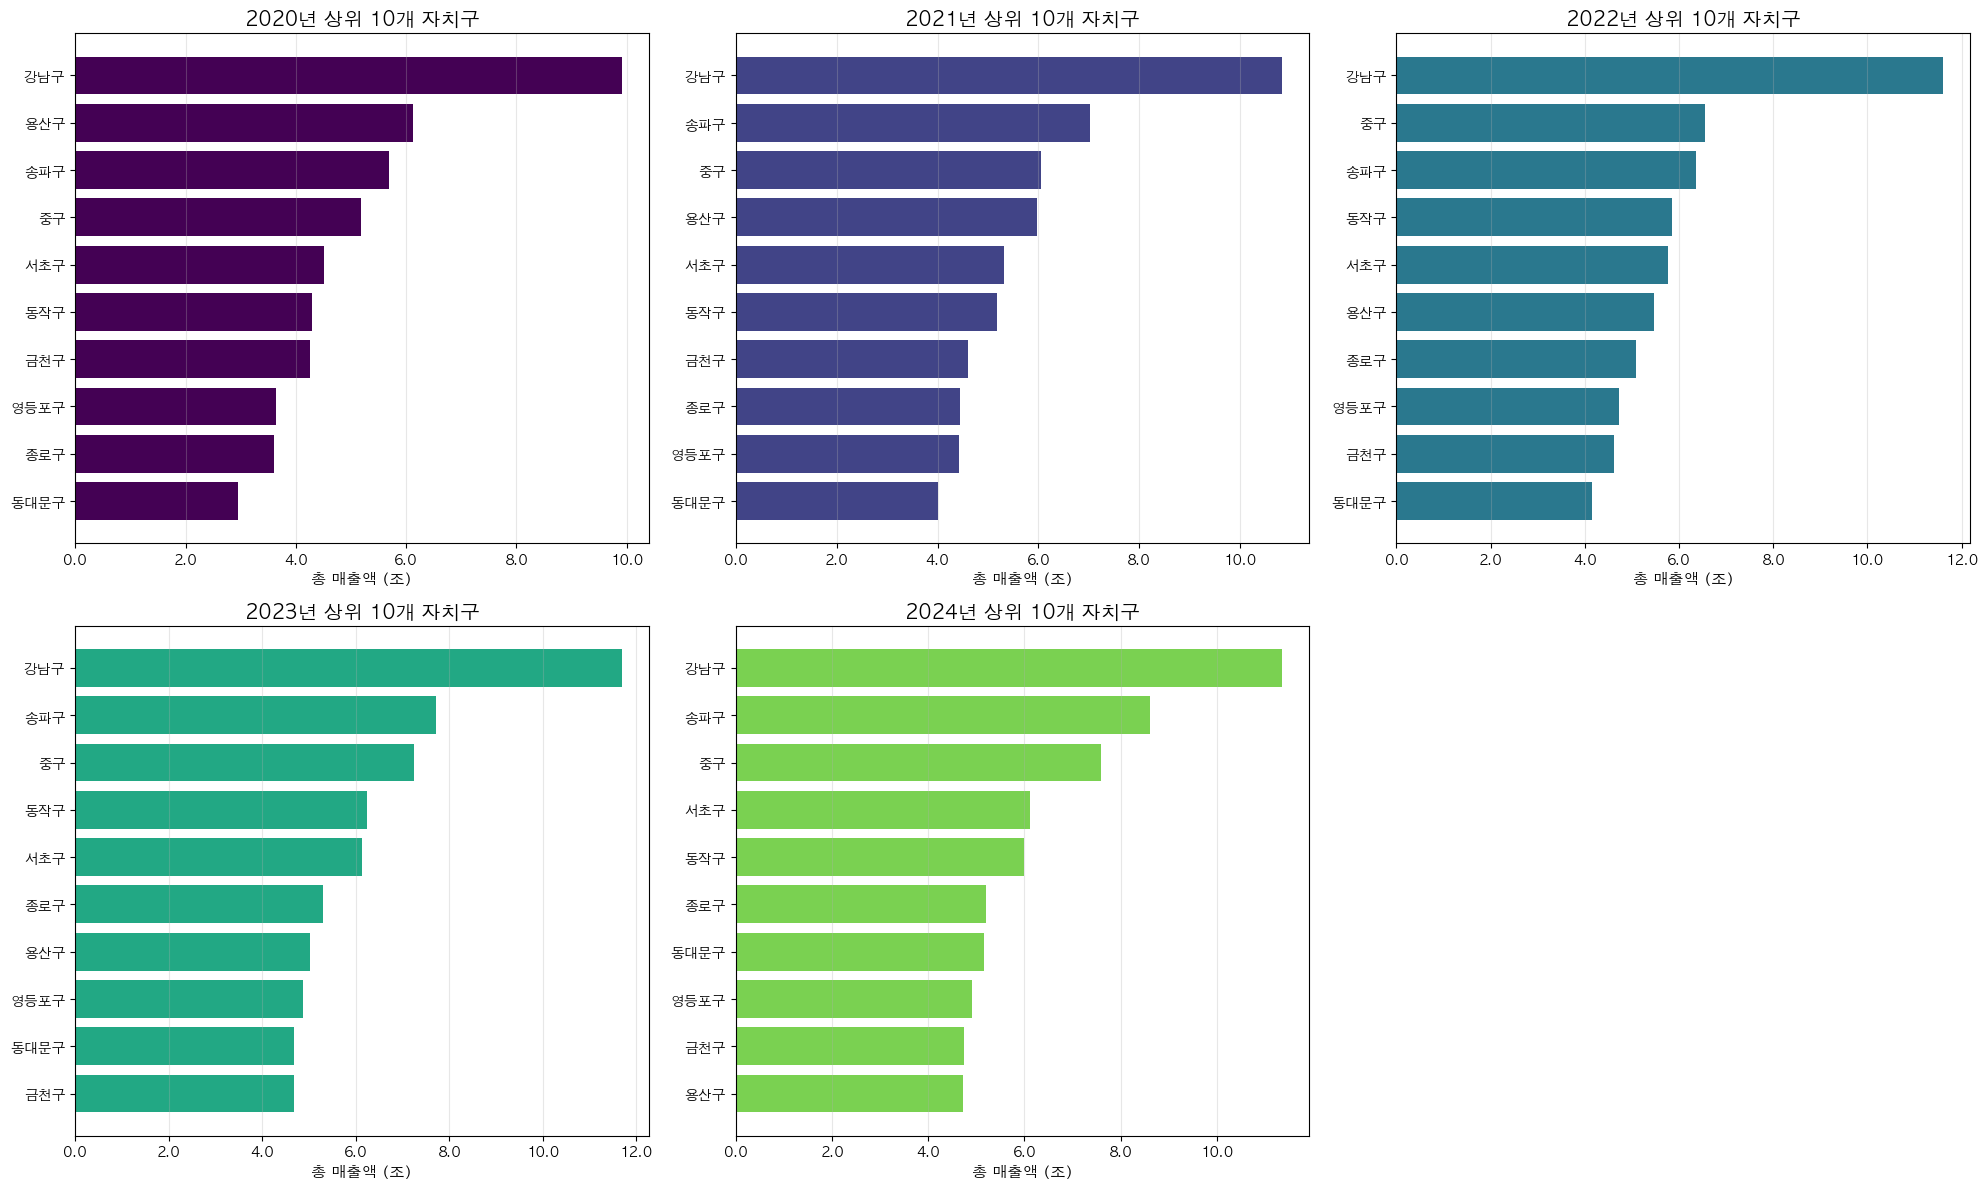

In [19]:
# 연도별 상위 10개 자치구 비교 (막대 차트)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

years = sorted(df['YEAR'].unique())

for idx, year in enumerate(years):
    if idx < len(axes):
        # 해당 연도의 자치구별 매출
        year_data = sales_by_signgu_year[sales_by_signgu_year['YEAR'] == year].nlargest(10, 'THSMON_SELNG_AMT')
        
        axes[idx].barh(year_data['SIGNGU_NM'], year_data['THSMON_SELNG_AMT'], color=plt.cm.viridis(idx/len(years)))
        axes[idx].set_title(f'{year}년 상위 10개 자치구', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('총 매출액 (조)', fontsize=11)
        axes[idx].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x/1e12:.1f}"))
        axes[idx].grid(True, alpha=0.3, axis='x')
        axes[idx].invert_yaxis()

# 마지막 빈 subplot 숨기기 (5개 연도만 있으므로)
if len(years) < len(axes):
    axes[len(years)].axis('off')

plt.tight_layout()
plt.show()